In [1]:
# Step 1: Data Preprocessing
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, 
                                     Flatten, Conv2D, GlobalAveragePooling2D,
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_data_dir = 'C:/Users/danie/sign-language-alpha/data/asl_alphabet_train/asl_alphabet_train'

def generate_dataset(path):
    data = {'path': [], 'label': []}
    
    folders = os.listdir(path)
    
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            
            data['path'].append(filepath)
            data['label'].append(folder)
    
    return pd.DataFrame(data)

df = generate_dataset(train_data_dir)
df.head(10)

,path,label
0,C:/Users/danie/sign-language-alpha/data/asl_al...,A
1,C:/Users/danie/sign-language-alpha/data/asl_al...,A
2,C:/Users/danie/sign-language-alpha/data/asl_al...,A
3,C:/Users/danie/sign-language-alpha/data/asl_al...,A
4,C:/Users/danie/sign-language-alpha/data/asl_al...,A
5,C:/Users/danie/sign-language-alpha/data/asl_al...,A
6,C:/Users/danie/sign-language-alpha/data/asl_al...,A
7,C:/Users/danie/sign-language-alpha/data/asl_al...,A
8,C:/Users/danie/sign-language-alpha/data/asl_al...,A
9,C:/Users/danie/sign-language-alpha/data/asl_al...,A


In [3]:
def dataset_splitter(dataset, train_size = 0.9, shuffle = True, random_state = 0):
    train_df, val_df = train_test_split(dataset, train_size = train_size, shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    
    return train_df, val_df

train_df, val_df = dataset_splitter(df)

In [4]:
BATCH_SIZE = 128
IMG_SIZE = (64, 64)

train_generator = ImageDataGenerator(1./255, 
                                     rotation_range = 10, 
                                     height_shift_range = 0.1, 
                                     width_shift_range = 0.1)

val_generator = ImageDataGenerator(1./255)

train_images = train_generator.flow_from_dataframe(train_df, x_col = 'path', y_col = 'label', 
                                                   color_mode = 'grayscale', class_mode = 'categorical',
                                                   batch_size = BATCH_SIZE, target_size = IMG_SIZE, 
                                                   shuffle = True, seed = 0)

val_images = val_generator.flow_from_dataframe(val_df, x_col = 'path', y_col = 'label', 
                                               color_mode = 'grayscale', class_mode = 'categorical', 
                                               batch_size = BATCH_SIZE, target_size = IMG_SIZE)

Found 74798 validated image filenames belonging to 29 classes.


C:\Users\danie\anaconda3\envs\myenv\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 8312 validated image filenames belonging to 29 classes.


In [5]:
df['label'].unique()  

array(['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U',
       'V', 'W', 'X', 'Y', 'Z'], dtype=object)

In [6]:
# output_shape = len(set(train_images.labels))

# model = Sequential([
#     Input(shape = IMG_SIZE + (1,), name = 'input_layer'),
    
#     Conv2D(16, (3, 3), activation = 'relu'),
#     MaxPooling2D(pool_size = (3, 3)),
    
#     Conv2D(32, (3, 3), activation = 'relu'),
#     MaxPooling2D(pool_size = (3, 3)),
    
#     Conv2D(64, (3, 3), activation = 'relu'),
#     MaxPooling2D(pool_size = (3, 3)),
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
    
#     Dense(512, activation = 'relu'),
#     Dropout(0.3),
    
#     Dense(512, activation = 'relu'),
    
#     Dense(output_shape, activation = 'softmax', name = 'output_layer')
# ])

# model.compile(optimizer = Adamax(learning_rate = 1e-3), 
#               loss = CategoricalCrossentropy(), 
#               metrics = ['accuracy'])

# model.summary()

In [7]:
# model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)

# history = model.fit(train_images, validation_data = val_images, epochs = 30, callbacks = [model_es])

In [8]:
# results = model.evaluate(val_images, verbose = 0)

# model.save("FINAL.h5")

# print("    Validation Loss: {:.5f}".format(results[0]))
# print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

In [9]:
import cv2
import numpy as np
from keras.models import load_model
import os

model = load_model("FINAL.h5")

class_mapping = train_images.class_indices

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    return predicted_labels

def predict_image_class(model, frame, class_mapping):
    # Convert the frame to grayscale
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize the image to 64x64
    img = np.expand_dims(cv2.resize(img, (64, 64)), axis=0)
    # Normalize the image
    img = img.astype('float32') / 255.0
    # Add the channel dimension
    img = np.expand_dims(img, axis=-1)
    # Make predictions
    predictions = np.argmax(model.predict(img, verbose=0), axis=1)
    # Get the predicted label
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame for prediction
    predicted_labels = predict_image_class(model, frame, class_mapping)
    
    # Display the predicted label on the frame
    cv2.putText(frame, predicted_labels[0], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Display the frame
    cv2.imshow('Sign Language Prediction', frame)
    
    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [10]:
print(class_mapping)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [11]:
import cv2
import os

# Define the path to the test image
test_image_path = r'C:\Users\danie\sign-language-alpha\data\asl_alphabet_test\asl_alphabet_test\A_test.jpg'  # Ensure the correct extension

# Check if the file exists
if os.path.exists(test_image_path):
    # Load the test image
    test_image = cv2.imread(test_image_path)
    
    if test_image is not None:
        # Print the size of the test image
        print(f"Test image size: {test_image.shape}")
    else:
        print("Error: Image could not be loaded. Please check the file format and path.")
else:
    print("Error: The file path does not exist.")


Test image size: (200, 200, 3)


In [12]:
import cv2

cap = cv2.VideoCapture(0)

# Capture a single frame
ret, frame = cap.read()

if ret:
    # Print the shape of the captured frame
    print(f"Webcam frame size: {frame.shape}")
else:
    print("Error: Could not capture frame from webcam.")

cap.release()


Webcam frame size: (480, 640, 3)


In [13]:
import cv2
import numpy as np
from keras.models import load_model

model = load_model("FINAL.h5")

class_mapping = train_images.class_indices

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    return predicted_labels


In [14]:
def predict_image_class(model, img, class_mapping):
    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image to 64x64
    img = cv2.resize(img, (64, 64))
    # Normalize the image
    img = img.astype('float32') / 255.0
    # Add batch dimension and channel dimension
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    
    # Print the shape to ensure it's correct
    print(f"Preprocessed image shape: {img.shape}")
    
    # Make predictions
    predictions = np.argmax(model.predict(img, verbose=0), axis=1)
    
    # Print the predictions
    print(f"Predictions: {predictions}")
    
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels[0]  # Return single label


In [15]:
imgs_dir = r'C:\Users\danie\sign-language-alpha\data\asl_alphabet_test\asl_alphabet_test'
imgs = os.listdir(imgs_dir)

class_mapping = train_images.class_indices

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]

    return predicted_labels

def predict_image_class(model, img_path, class_mapping):
    img = cv2.imread(os.path.join(imgs_dir, img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.resize(img, (64, 64)), axis = 0)
    predictions = np.argmax(model.predict(img, verbose = 0), axis = 1)
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels

import cv2
import numpy as np

def process_and_save_video_frame(frame, save_path="processed_frame.jpg"):
    """
    Process a video frame: convert to grayscale, resize with aspect ratio,
    normalize, reshape, and save the processed frame.
    
    Args:
        frame: The original video frame captured from the webcam.
        save_path: The path to save the processed frame image.
    
    Returns:
        frame_final: The processed frame ready for model input.
    """
    def resize_with_aspect_ratio(image, target_size):
        h, w = image.shape[:2]
        target_w, target_h = target_size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(image, (new_w, new_h))
        delta_w, delta_h = target_w - new_w, target_h - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        color = [0, 0, 0]
        new_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        return new_image

    print(f"Original Frame shape: {frame.shape}")
    
    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Resize with aspect ratio
    frame_resized = resize_with_aspect_ratio(frame_gray, (64, 64))
    print(f"Shape after resizing with aspect ratio to 64x64: {frame_resized.shape}")
    
    # Normalize
    frame_normalized = frame_resized.astype('float32') / 255.0
    
    # Add batch and channel dimensions
    frame_final = np.expand_dims(frame_normalized, axis=0)
    frame_final = np.expand_dims(frame_final, axis=-1)
    print(f"Shape after adding batch and channel dimensions: {frame_final.shape}")
    
    # Save the processed frame
    cv2.imwrite(save_path, frame_resized * 255)
    
    return frame_final


for img in imgs:
    predicted_labels = predict_image_class(model, img, class_mapping)
    print(f'Predicted Labels {img} -----> {predicted_labels}')

Predicted Labels A_test.jpg -----> ['A']
Predicted Labels B_test.jpg -----> ['B']
Predicted Labels C_test.jpg -----> ['C']
Predicted Labels D_test.jpg -----> ['D']
Predicted Labels E_test.jpg -----> ['E']
Predicted Labels F_test.jpg -----> ['F']
Predicted Labels G_test.jpg -----> ['G']
Predicted Labels H_test.jpg -----> ['H']
Predicted Labels I_test.jpg -----> ['I']
Predicted Labels J_test.jpg -----> ['J']
Predicted Labels K_test.jpg -----> ['K']
Predicted Labels L_test.jpg -----> ['L']
Predicted Labels M_test.jpg -----> ['M']
Predicted Labels nothing_test.jpg -----> ['nothing']
Predicted Labels N_test.jpg -----> ['N']
Predicted Labels O_test.jpg -----> ['O']
Predicted Labels P_test.jpg -----> ['P']
Predicted Labels Q_test.jpg -----> ['Q']
Predicted Labels R_test.jpg -----> ['R']
Predicted Labels space_test.jpg -----> ['space']
Predicted Labels S_test.jpg -----> ['S']
Predicted Labels T_test.jpg -----> ['T']
Predicted Labels U_test.jpg -----> ['U']
Predicted Labels V_test.jpg -----> ['

In [16]:
# Refactored code example
import os
import cv2
import numpy as np
from keras.models import load_model

model = load_model("FINAL.h5")
imgs_dir = r'C:\Users\danie\sign-language-alpha\data\asl_alphabet_test\asl_alphabet_test'
imgs = os.listdir(imgs_dir)

class_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
print(f"Class mapping: {class_mapping}")

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    print(predicted_labels)
    return predicted_labels

def preprocess_and_predict(model, img, class_mapping, target_size=(64, 64)):
    print(f"Original image shape: {img.shape}")
    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(f"Shape after converting to grayscale: {img.shape}")
    # Resize the image
    img = cv2.resize(img, target_size)
    print(f"Shape after resizing to {target_size}: {img.shape}")
    # Normalize the image
    img = img.astype('float32') / 255.0
    # Add batch dimension and channel dimension
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    print(f"Shape after adding batch and channel dimensions: {img.shape}")
    # Make predictions
    predictions = np.argmax(model.predict(img, verbose=0), axis=1)
    print(f"Predictions: {predictions}")
    # Get the predicted label
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels

def predict_image_class_from_path(model, img_path, class_mapping):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to load image at path {img_path}")
        return ["Error"]
    return preprocess_and_predict(model, img, class_mapping)

def predict_image_class_from_frame(model, frame, class_mapping):
    return preprocess_and_predict(model, frame, class_mapping)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_resized = cv2.resize(frame, (200, 200))
    predicted_labels = predict_image_class_from_frame(model, frame_resized, class_mapping)
    
    # Display the predicted label on the frame
    cv2.putText(frame_resized, predicted_labels[0], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Display the frame
    cv2.imshow('Sign Language Prediction', frame_resized)
    
    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Class mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Original image shape: (200, 200, 3)
Shape after converting to grayscale: (200, 200)
Shape after resizing to (64, 64): (64, 64)
Shape after adding batch and channel dimensions: (1, 64, 64, 1)
Predictions: [27]
['nothing']
Original image shape: (200, 200, 3)
Shape after converting to grayscale: (200, 200)
Shape after resizing to (64, 64): (64, 64)
Shape after adding batch and channel dimensions: (1, 64, 64, 1)
Predictions: [27]
['nothing']
Original image shape: (200, 200, 3)
Shape after converting to grayscale: (200, 200)
Shape after resizing to (64, 64): (64, 64)
Shape after adding batch and channel dimensions: (1, 64, 64, 1)
Predictions: [27]
['nothing']
Original image shape: (200, 200, 3)
Shape after converting

In [17]:
import cv2
import numpy as np

# Process a JPEG Image
def process_jpeg_image(image_path):
    img = cv2.imread(image_path)
    print(f"JPEG Image shape: {img.shape}")
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (64, 64))
    img_normalized = img_resized.astype('float32') / 255.0
    img_final = np.expand_dims(img_normalized, axis=0)
    img_final = np.expand_dims(img_final, axis=-1)
    print(f"Processed JPEG shape: {img_final.shape}")
    return img_final

# Process a Video Frame
def process_video_frame(frame):
    print(f"Original Frame shape: {frame.shape}")
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_resized = cv2.resize(frame_gray, (64, 64))
    frame_normalized = frame_resized.astype('float32') / 255.0
    frame_final = np.expand_dims(frame_normalized, axis=0)
    frame_final = np.expand_dims(frame_final, axis=-1)
    print(f"Processed Frame shape: {frame_final.shape}")
    return frame_final

# Example usage for a JPEG image
jpeg_path = r'C:\Users\danie\sign-language-alpha\data\asl_alphabet_test\asl_alphabet_test\H_test.jpg'
processed_jpeg = process_jpeg_image(jpeg_path)

# Example usage for a video frame
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if ret:
    processed_frame = process_video_frame(frame)
cap.release()


JPEG Image shape: (200, 200, 3)
Processed JPEG shape: (1, 64, 64, 1)
Original Frame shape: (480, 640, 3)
Processed Frame shape: (1, 64, 64, 1)


In [18]:
import os
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model("FINAL.h5")

# Assuming class_mapping is already defined
class_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    return predicted_labels

def resize_with_aspect_ratio(image, target_size):
    h, w = image.shape[:2]
    target_w, target_h = target_size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    delta_w, delta_h = target_w - new_w, target_h - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

# Process a JPG Image
def process_jpg_image(image_path):
    img = cv2.imread(image_path)
    print(f"JPG Image shape: {img.shape}")
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = resize_with_aspect_ratio(img_gray, (64, 64))
    print(f"Shape after resizing with aspect ratio to 64x64: {img_resized.shape}")
    img_normalized = img_resized.astype('float32') / 255.0
    img_final = np.expand_dims(img_normalized, axis=0)
    img_final = np.expand_dims(img_final, axis=-1)
    print(f"Shape after adding batch and channel dimensions: {img_final.shape}")

    # Save the processed JPG image
    cv2.imwrite("processed_jpg_image.jpg", img_resized * 255)
    return img_final

# Process a Video Frame
def process_video_frame(frame):
    print(f"Original Frame shape: {frame.shape}")
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_resized = resize_with_aspect_ratio(frame_gray, (64, 64))
    print(f"Shape after resizing with aspect ratio to 64x64: {frame_resized.shape}")
    frame_normalized = frame_resized.astype('float32') / 255.0
    frame_final = np.expand_dims(frame_normalized, axis=0)
    frame_final = np.expand_dims(frame_final, axis=-1)
    print(f"Shape after adding batch and channel dimensions: {frame_final.shape}")

    # Save the processed frame
    cv2.imwrite("processed_frame.jpg", frame_resized * 255)
    return frame_final

# Prediction Function using Processed Data
def predict_image_class(model, processed_img, class_mapping):
    predictions = model.predict(processed_img, verbose=0)
    print(f"Raw predictions: {predictions}")
    predictions = np.argmax(predictions, axis=1)
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels

# Example usage for a JPG image
jpg_path = r'C:\Users\danie\sign-language-alpha\data\asl_alphabet_test\asl_alphabet_test\H_test.jpg'
processed_jpg = process_jpg_image(jpg_path)
predicted_labels_jpg = predict_image_class(model, processed_jpg, class_mapping)
print(f'Predicted Labels for JPG image: {predicted_labels_jpg}')

# Example usage for a video frame
def video_capture():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        processed_frame = process_video_frame(frame)
        predicted_labels_frame = predict_image_class(model, processed_frame, class_mapping)
        
        # Display the predicted label on the frame
        cv2.putText(frame, predicted_labels_frame[0], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        # Display the frame
        cv2.imshow('Sign Language Prediction', frame)
        
        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Run the video capture function
video_capture()


JPG Image shape: (200, 200, 3)
Shape after resizing with aspect ratio to 64x64: (64, 64)
Shape after adding batch and channel dimensions: (1, 64, 64, 1)
Raw predictions: [[1.4065782e-22 3.6432651e-31 3.7672650e-26 6.7335503e-26 2.3351762e-22
  4.3840678e-31 7.2491962e-10 9.8980525e-17 1.2075570e-13 1.6498169e-21
  8.4577683e-12 6.7616639e-32 0.0000000e+00 7.8710186e-28 1.3291365e-32
  6.2411753e-23 2.8736903e-19 1.9300729e-12 1.8730242e-25 4.6223581e-18
  5.3001415e-27 1.0427940e-16 2.9006203e-25 4.0473392e-07 3.8958375e-23
  2.6635135e-12 3.0512873e-12 9.9999964e-01 3.9782247e-16]]
Predicted Labels for JPG image: ['nothing']
Original Frame shape: (480, 640, 3)
Shape after resizing with aspect ratio to 64x64: (64, 64)
Shape after adding batch and channel dimensions: (1, 64, 64, 1)
Raw predictions: [[1.7203472e-22 4.3862086e-31 4.3865372e-26 8.5563434e-26 3.0558964e-22
  6.2210885e-31 9.9018060e-10 1.2577006e-16 1.5211445e-13 2.3017906e-21
  9.7651817e-12 8.2894933e-32 0.0000000e+00 9.4

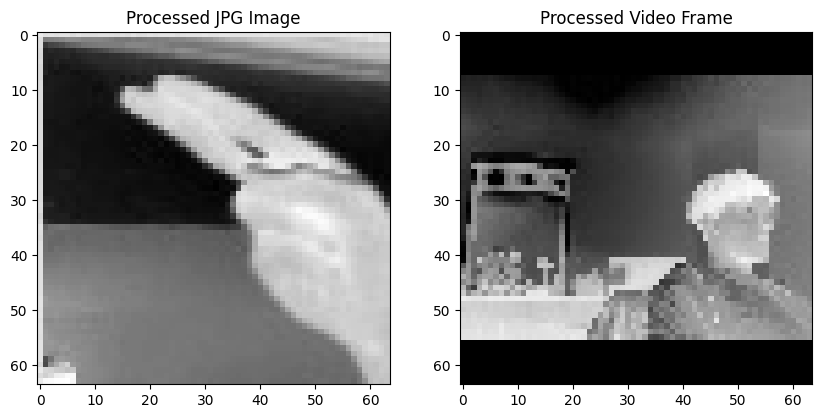

Processed JPG Image:
Shape: (64, 64)
Mean: 153.66650390625
Standard Deviation: 47.88266513258429
Pixel Values (first 5x5 block):
[[230 224 225 223 225]
 [221 158 159 161 163]
 [222 113 120 123 128]
 [219  98 102  99 101]
 [218  98  97  98  99]]

Processed Video Frame:
Shape: (64, 64)
Mean: 79.198486328125
Standard Deviation: 69.05247670231982
Pixel Values (first 5x5 block):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

Difference Between Images (first 5x5 block):
[[230 224 225 223 225]
 [221 158 159 161 163]
 [222 113 120 123 128]
 [219  98 102  99 101]
 [218  98  97  98  99]]
Mean Difference: 123.155517578125, Std Difference: 73.55317010068988


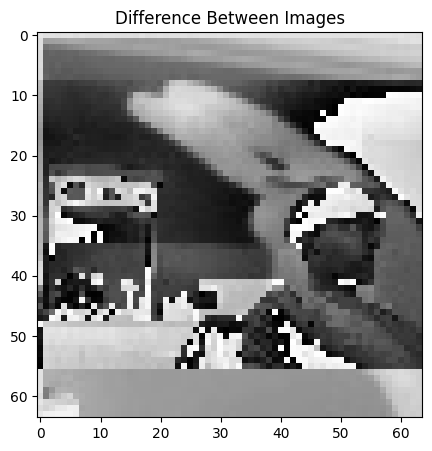

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load, display, and print detailed aspects of images
def load_display_and_analyze_images(jpg_path, frame_path):
    # Load images
    processed_jpg = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)
    processed_frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

    # Display images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Processed JPG Image")
    plt.imshow(processed_jpg, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Processed Video Frame")
    plt.imshow(processed_frame, cmap='gray')

    plt.show()

    # Print detailed aspects
    print("Processed JPG Image:")
    print(f"Shape: {processed_jpg.shape}")
    print(f"Mean: {np.mean(processed_jpg)}")
    print(f"Standard Deviation: {np.std(processed_jpg)}")
    print(f"Pixel Values (first 5x5 block):\n{processed_jpg[:5, :5]}")

    print("\nProcessed Video Frame:")
    print(f"Shape: {processed_frame.shape}")
    print(f"Mean: {np.mean(processed_frame)}")
    print(f"Standard Deviation: {np.std(processed_frame)}")
    print(f"Pixel Values (first 5x5 block):\n{processed_frame[:5, :5]}")

    return processed_jpg, processed_frame

# Function to compare images
def compare_images(img1, img2):
    # Calculate difference
    difference = np.abs(img1 - img2)
    print(f"\nDifference Between Images (first 5x5 block):\n{difference[:5, :5]}")
    print(f"Mean Difference: {np.mean(difference)}, Std Difference: {np.std(difference)}")

    # Display difference
    plt.figure(figsize=(5, 5))
    plt.title("Difference Between Images")
    plt.imshow(difference, cmap='gray')
    plt.show()

# Paths to saved images
jpg_path = "processed_jpg_image.jpg"
frame_path = "processed_frame.jpg"

# Load, display, and analyze images
processed_jpg, processed_frame = load_display_and_analyze_images(jpg_path, frame_path)

# Compare images
compare_images(processed_jpg, processed_frame)
